# 0301_Modeling_Sample.ipynbを参考に0202_Preprocessing_niko.ipynbを実装

## ライブラリのインポート

In [589]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic" # 日本語の文字化け防止
import seaborn as sns
sns.set(font="IPAexGothic",style="darkgrid")
pd.set_option("display.max_columns", 50) #jupyter notebook上で表示できるカラム数を50に設定

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

# LightGBM用
# LightGBMライブラリ
import lightgbm as lgb
# 訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

## データの読み込み

In [590]:
train = pd.read_csv("data/create/train_all_column_addition.csv")
test = pd.read_csv("data/create/test_all_column_addition.csv")
sample = pd.read_csv("data/received/sample_submit.csv",header=None)

## ①重回帰モデル

### get_dummiesで文字列を0 or 1で表す
### testにないデータもあるので結合して保管する

In [591]:
train.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'tv_num', 'home_lat',
       'home_long', 'away_lat', 'away_long', 'distance_km', 'mobilization',
       'stage_stadium', 'stadium_mobilization', 'MONTH', 'WEEK', 'timezone',
       'WEEK_timezone_num', 'nhk', 'WEATHER', 'temp_condition', 'hours',
       'over_mobilization', 'holiday', 'referee_point', 'stadium_min',
       'stadium_max'],
      dtype='object')

In [592]:
# 結合前にtrainというフラグを作り、trainデータは1、testデータは0とする
train["train"] = 1
test["train"] = 0

# 結合
dat = pd.concat([train,test],sort=False)
# この時trainフラグも忘れない
select_cols = ['year', 'stage', 'home', 'away','capa',
       'temperature', 'tv_num',  'distance_km', 'referee', #'stadium_mobilization', 
       'MONTH', 'WEEK', 'timezone', 'nhk', 'WEATHER', 'holiday', 'train', 'referee_point', 'stadium_min',
       'stadium_max']
datX = pd.get_dummies(dat[select_cols],drop_first=True)
# datXにおいてtrainフラグが1のものをtrainXとする。その後、trainフラグを削除
trainX = datX[datX["train"]==1]
trainX = trainX.drop(columns="train")

# datXにおいてtrainフラグが0のものをtestXとする。その後、trainフラグを削除
testX = datX[datX["train"]==0]
testX = testX.drop(columns="train")

y = train["y"]
trainX.head()

,year,capa,temperature,tv_num,distance_km,MONTH,timezone,nhk,holiday,referee_point,stadium_min,stadium_max,stage_Ｊ２,home_アルビレックス新潟,home_カターレ富山,home_カマタマーレ讃岐,home_ガイナーレ鳥取,home_ガンバ大阪,home_ギラヴァンツ北九州,home_コンサドーレ札幌,home_サガン鳥栖,home_サンフレッチェ広島,home_ザスパクサツ群馬,home_ザスパ草津,home_ジェフユナイテッド千葉,...,referee_松尾 一,referee_松村 和彦,referee_森川 浩次,referee_榎本 一慶,referee_池内 明彦,referee_河合 英治,referee_福島 孝一郎,referee_窪田 陽輔,referee_篠藤 巧,referee_荒木 友輔,referee_西村 雄一,referee_野田 祐樹,referee_長谷 拓,referee_飯田 淳平,referee_高山 啓義,WEEK_日,WEEK_月,WEEK_木,WEEK_水,WEEK_火,WEEK_金,WEATHER_晴,WEATHER_曇,WEATHER_雨,WEATHER_雪
0,2012,19694,3.8,4,259.062331,3,1,1,0,1,11144,18863,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2012,40000,12.4,4,120.059935,3,1,0,0,1,12075,38966,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012,21000,11.3,4,38.255309,3,1,0,0,0,6559,19393,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,2012,50000,11.4,4,685.986038,3,1,0,0,1,9515,32724,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2012,39232,22.5,4,966.885906,3,1,0,0,1,6646,25353,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### モデルの準備及び学習

In [593]:
model1 = LR()
model1.fit(trainX,y)

LinearRegression()

### 予測値の最小値を確認

In [594]:
pred = model1.predict(trainX)
print("MIN", pred.min(), train[train["y"]>0]["y"].min())
# 予測値が学習データの最小値を下回るケースは12ケース
print(pred[pred<train[train["y"]>0]["y"].min()])

MIN -4341.668609619141 1104
[ 1029.28594971   717.86282349  -619.06036377   270.08392334
   732.50894165  -469.00189209    -8.91967773   512.12533569
 -4179.9223938  -3228.21325684   480.86331177   -13.31729126
  -834.00531006   -99.46066284   630.1111145  -1107.8979187
   408.37460327   -28.02438354  -324.77005005    39.15512085
  -266.51754761 -4341.66860962   443.24765015]


### trainデータへの当てはまりの確認（予測値と実績値のRMSEを算出）
- 2853.562521905859

In [595]:
# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換
min_values = train[train["y"]>0]["y"].min()
pred[pred<min_values] = min_values
# sklearnではRMSEはなく、MSEしかないので一旦、MSEを算出
mse = MSE(pred,y)
# MSEにルートを取ったものがRMSEなので、mseに0.5乗して求める
rmse = mse**0.5
rmse

2914.8997377334254

#### 学習データへの予測結果の可視化
- 散布図を使う
- x軸を予測値、y軸を実績値とする

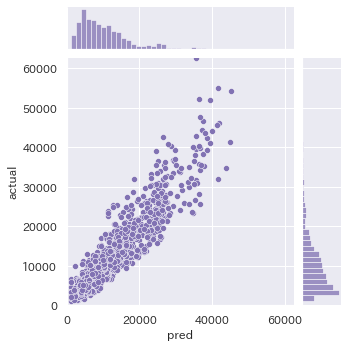

In [596]:
tmp = pd.DataFrame({"pred":pred,"actual":y})
g = sns.jointplot(x="pred", y="actual", data=tmp,
                  xlim=(0, tmp["actual"].max()), ylim=(0, tmp["actual"].max()),
                  color="m", height=5)

- 実績値の値域を3分割し、各分割毎に実績値、予測値、（実績値-予測値）の平均を算出

In [597]:
tmp["class"] = pd.cut(tmp["actual"],3)
tmp["sub"] = tmp["pred"]-tmp["actual"]
tmp.groupby(by="class").mean()

,pred,actual,sub
class,,,
"(1042.472, 21613.333]",8881.284651,8575.460840,305.823811
"(21613.333, 42122.667]",26139.585895,28155.988571,-2016.402676
"(42122.667, 62632.0]",38128.346250,48151.133333,-10022.787083


#### Cross Validation（汎化性能の確認）
- 学習データを構築データと検証データに分割して汎化性能を評価
- 恐らくコンペに投稿してもこのぐらいのスコアになる

In [598]:
model = LR()
cv = cross_val_score(model, trainX, y, cv=5, scoring="neg_root_mean_squared_error")
print(cv)
print(cv.mean())

[-3.78916913e+03 -2.31643222e+03 -4.14228436e+03 -4.16012383e+10
 -2.91610353e+10]
-14152456769.403986


##### 投稿用ファイルの作成
- この予測値をSIGNATEに投稿すると、RMSEは3,575程度

In [599]:
pred_LR1 = model1.predict(testX)
pred_LR1_df = pd.DataFrame(pred_LR1, columns = ['pre'])
# test_min_df = test.loc[:,['stadium_min']]
pred_LR1_df=pred_LR1_df.join([test.loc[:,['stadium_min','capa']]])
pred_LR1_df.head(20)

,pre,stadium_min,capa
0,13733.345184,11144,19694
1,17924.818939,6681,40728
2,37183.420746,23295,63700
3,13406.637177,7013,15349
4,28837.373016,15854,42300
5,13750.387421,6559,21000
6,4156.068268,1875,19637
7,15298.159912,6292,24490
8,13716.333130,7412,15600
9,23310.792969,12345,26530


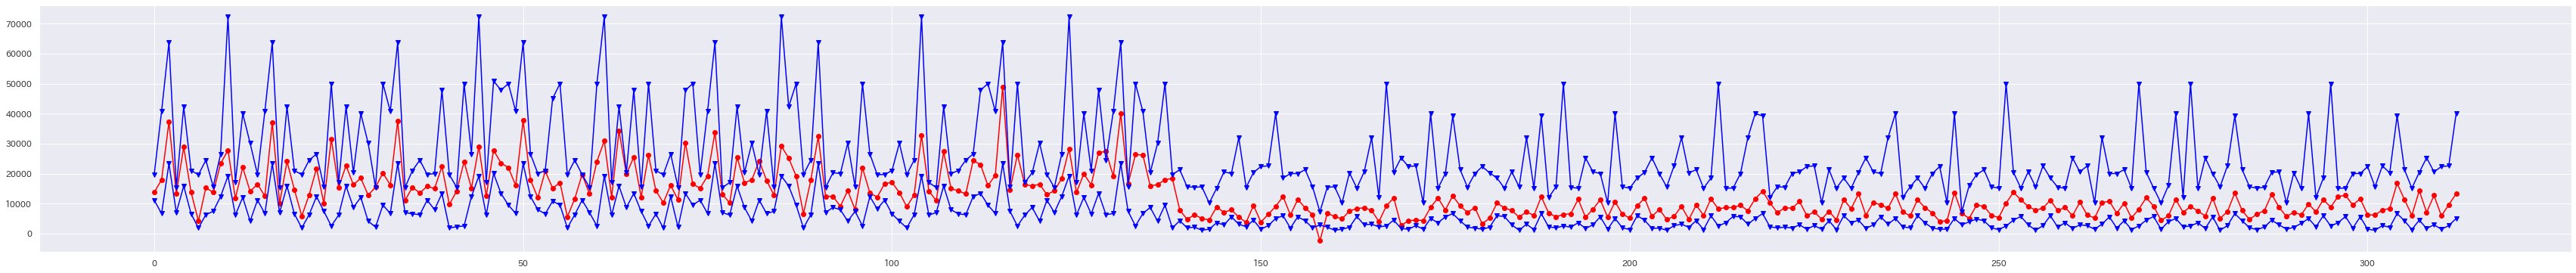

In [600]:
#ライブラリのインポート
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(60, 6))
# 予測値
plt.plot(pred_LR1_df.index, pred_LR1_df['pre'], color = 'red', marker = 'o')

# スタジオのcapaとスタジオの実績最小値
plt.plot(pred_LR1_df.index, pred_LR1_df['capa'], color = 'blue', marker = 'v')
plt.plot(pred_LR1_df.index, pred_LR1_df['stadium_min'], color = 'blue', marker = 'v')

plt.show()

In [601]:

# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換

pred_LR1[pred_LR1<min_values] = min_values
sample[1] = pred_LR1
sample.to_csv("data/predict/0321_Modeling_01.csv",index=None,header=None)

## ②RandomForestで予測をしてみる

In [602]:
from sklearn.ensemble import RandomForestRegressor as RF

#### モデルの箱を用意します
- パラメータは決定木と同じように、max_depthとmin_samples_leafが重要です
- これに加え、RandomForestでは沢山の木を作りますが、いくつ作るかどうかがn_estimatorsになります

In [603]:
rf = RF(n_estimators=10,max_depth=20,min_samples_leaf=20,n_jobs=-1,random_state=0)

#### 用意したtrainXで学習をする

In [604]:
rf.fit(trainX,y)

RandomForestRegressor(max_depth=20, min_samples_leaf=20, n_estimators=10,
                      n_jobs=-1, random_state=0)

#### tree系の手法では特徴量の重要度を見ることができます

In [605]:
imp = rf.feature_importances_
imp

array([1.27495473e-03, 1.28696557e-02, 4.85481297e-03, 8.20947926e-04,
       1.07244892e-02, 1.04313778e-02, 5.81250184e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.14211582e-01, 2.42011025e-01,
       4.77736814e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.18187265e-06, 0.00000000e+00,
       8.94131484e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.66093301e-04, 1.46234830e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.65232482e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.09334218e-05,
       0.00000000e+00, 1.71240049e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.86879838e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.22572479e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [606]:
im = pd.DataFrame(imp,columns=["imp"])
im.index = trainX.columns
im.head()

,imp
year,0.001275
capa,0.012870
temperature,0.004855
tv_num,0.000821
distance_km,0.010724


In [607]:
im = im.sort_values(by="imp",ascending=False)
im.head()

,imp
stage_Ｊ２,0.477737
stadium_max,0.242011
stadium_min,0.214212
home_浦和レッズ,0.018688
capa,0.012870


<AxesSubplot:xlabel='imp'>

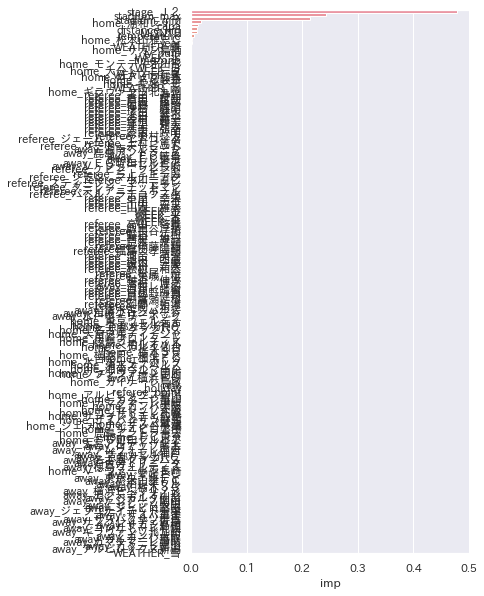

In [608]:
plt.figure(figsize=(5,10))
sns.barplot(x="imp", y=im.index, data=im)

##### trainデータへの当てはまりの確認（予測値と実績値のRMSEを算出）
3373

In [609]:
pred = rf.predict(trainX)
# sklearnではRMSEはなく、MSEしかないので一旦、MSEを算出
mse = MSE(pred,y)
# MSEにルートを取ったものがRMSEなので、mseに0.5乗して求める
rmse = mse**0.5
rmse

3311.584451974421

##### 学習データへの予測結果の可視化
- 散布図を使う
- x軸を予測値、y軸を実績値とする

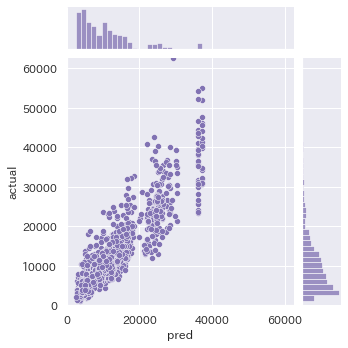

In [610]:
tmp = pd.DataFrame({"pred":pred,"actual":y})
g = sns.jointplot(x="pred", y="actual", data=tmp,
                  xlim=(0, tmp["actual"].max()), ylim=(0, tmp["actual"].max()),
                  color="m", height=5)

- 実績値の値域を3分割し、各分割毎に実績値、予測値、（実績値-予測値）の平均を算出

In [611]:
tmp["class"] = pd.cut(tmp["actual"],3)
tmp["sub"] = tmp["pred"]-tmp["actual"]
tmp.groupby(by="class").mean()

,pred,actual,sub
class,,,
"(1042.472, 21613.333]",8950.372733,8575.460840,374.911893
"(21613.333, 42122.667]",25944.434856,28155.988571,-2211.553716
"(42122.667, 62632.0]",35375.609434,48151.133333,-12775.523900


##### Cross Validation（汎化性能の確認）
- 学習データを構築データと検証データに分割して汎化性能を評価
- 恐らくコンペに投稿してもこのぐらいのスコアになる

In [612]:
model = RF(n_estimators=10,max_depth=20,min_samples_leaf=20,n_jobs=-1,random_state=0)
cv = cross_val_score(model, trainX, y, cv=5, scoring="neg_root_mean_squared_error")
print(cv)
print(cv.mean())

[-4161.13126625 -2319.58225159 -5007.28123866 -3029.57854251
 -3620.71610105]
-3627.657880010562


## ③複数モデルをアンサンブル
- 下記の手順でモデルを作っていきます
    1. 複数のアルゴリズムを使い、モデルを作ります。
    1. 具体的には、①で作ったモデルに加えて、決定木とランダムフォレストの２つを更に作ります
    1. 説明変数は①で作ったものを流用し、グリッドサーチでパラメータを選出します
    1. 3つのモデルが完成したら、それぞれのモデルでtestへの予測値を算出し、平均化します
- 応用として、グループ内でAさん、Bさん、Cさんそれぞれが作ったモデルの予測値を平均することも考えられます

### ライブラリのインポートから

In [613]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import GridSearchCV

### モデルの箱を用意します

In [614]:
dt = DT()
rf = RF()

### グリッドサーチでパラメータを探索
- 決定木

In [615]:
# 今回の問題の評価関数はRMSEなので、MSEが良いパラメータを選択
param_DT = {"max_depth":[5,10,20],"min_samples_leaf":[5,10,20]}
gcv_DT = GridSearchCV(dt,param_DT,cv=5,scoring="neg_root_mean_squared_error",n_jobs=-1,return_train_score=True)
gcv_DT.fit(trainX,y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [5, 10, 20]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [616]:
# グリッドサーチの結果を見てみる
train_score_DT = gcv_DT.cv_results_["mean_train_score"]
test_score_DT = gcv_DT.cv_results_["mean_test_score"]

# それぞれRMSEに-1を掛けたものが、cvの数だけ入っているので、絶対値(np.fabs)を取り、その平均値をとる
train_score_DT = np.mean(np.fabs(train_score_DT))
test_score_DT = np.mean(np.fabs(test_score_DT))

print("train_score",train_score_DT)
print("test_score",test_score_DT)

train_score 3043.656791062728
test_score 3765.7732793428813


- ランダムフォレスト

In [617]:
param_RF = {"n_estimators":[50,100,150],"max_depth":[5,10,20],"max_features":[5,10,20]}
gcv_RF = GridSearchCV(rf,param_RF,cv=5,scoring="neg_root_mean_squared_error",n_jobs=-1,return_train_score=True)
gcv_RF.fit(trainX,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20], 'max_features': [5, 10, 20],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [618]:
# グリッドサーチの結果を見てみる
train_score_RF = gcv_RF.cv_results_["mean_train_score"]
test_score_RF = gcv_RF.cv_results_["mean_test_score"]

# それぞれRMSEに-1を掛けたものが、cvの数だけ入っているので、絶対値(np.fabs)を取り、その平均値をとる
train_score_RF = np.mean(np.fabs(train_score_RF))
test_score_RF = np.mean(np.fabs(test_score_RF))

print("train_score",train_score_RF)
print("test_score",test_score_RF)

train_score 3121.878285009379
test_score 4177.402103341085


- グリッドサーチで選択されたパラメータを表示

In [619]:
print("DT", gcv_DT.best_params_)
print("RF", gcv_RF.best_params_)

DT {'max_depth': 10, 'min_samples_leaf': 20}
RF {'max_depth': 20, 'max_features': 20, 'n_estimators': 50}


### アンサンブルモデルの時のCross Validation
- 複数のモデルで構築データを学習し、検証データで予測を実施しなければならない為、自身でcross validationのコードを記述する必要がある
- KFold関数を利用して実装する

In [620]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [621]:
cv = []
for train_index, test_index in kf.split(trainX, y):
    # 構築用データ
    trX = trainX.iloc[train_index]
    y_tr = y.iloc[train_index]
    # 検証用データ
    teX = trainX.iloc[test_index]
    y_te = y.iloc[test_index]
    
    # 構築用データでモデル作成（今回は3モデルのアンサンブルの為、3モデルを定義。パラメータはグリッドサーチの結果を利用）
    lr = LR()
    dt = DT(max_depth=20, min_samples_leaf=20)
    rf = RF(max_depth=10, max_features=20, n_estimators=50)
    lr.fit(trX, y_tr)
    dt.fit(trX, y_tr)
    rf.fit(trX, y_tr)
    
    # 検証用データへの予測
    pred1 = lr.predict(teX)
    pred2 = dt.predict(teX)
    pred3 = rf.predict(teX)
    
    # 予測のアンサンブル
    pred = (pred1 + pred2 + pred3) / 3
    
    # 評価
    mse = MSE(pred,y_te)
    rmse = mse**0.5
    cv.append(rmse)

# cvの結果を表示
print(cv)
print(np.array(cv).mean())

[3030.6311328996167, 3169.670539614666, 120889.81957284389, 3753.5946655437237, 5581945.0647770995]
1142557.7561376004


### testを予測

In [622]:
pred_DT = gcv_DT.predict(testX)
pred_RF = gcv_RF.predict(testX)

### 一旦、それぞれのモデルの予測結果を投稿できる形で出力

In [623]:
sample[1] = pred_LR1
sample.to_csv("LR_pred1.csv",index=None,header=None)
sample[1] = pred_DT
sample.to_csv("DT_pred1.csv",index=None,header=None)
sample[1] = pred_RF
sample.to_csv("RF_pred1.csv",index=None,header=None)

### 3つのモデルの予測結果を使い、新しいデータフレームを作成

In [624]:
pred = pd.DataFrame({"LR":pred_LR1,"DT":pred_DT,"RF":pred_RF})
pred

,LR,DT,RF
0,13733.345184,17107.818182,14541.582807
1,17924.818939,15787.344828,17447.707307
2,37183.420746,33879.800000,35008.968000
3,13406.637177,12592.619048,12053.055929
4,28837.373016,26878.307692,26920.390385
...,...,...,...
308,7068.078125,4500.515152,5120.929371
309,12692.518219,8932.300000,10149.185612
310,5913.118134,3656.850000,4716.689132
311,9587.053925,7561.857143,6988.529271


### 3つの予測値の平均を求める
- mean関数を使いますが、縦方向の平均ではなく、横方向の平均を求めるので、オプションに`axis=1`をつける

In [625]:
pred["mean"] = pred.mean(axis=1)
pred.head()

,LR,DT,RF,mean
0,13733.345184,17107.818182,14541.582807,15127.582058
1,17924.818939,15787.344828,17447.707307,17053.290358
2,37183.420746,33879.800000,35008.968000,35357.396249
3,13406.637177,12592.619048,12053.055929,12684.104051
4,28837.373016,26878.307692,26920.390385,27545.357031


### 投稿ファイルとして書き出し
- この予測値をSIGNATEに投稿すると、RMSEは3,352程度

In [626]:
sample[1] = pred["mean"]
sample.to_csv("data/predict/0321_Modeling_02.csv",index=None,header=None)

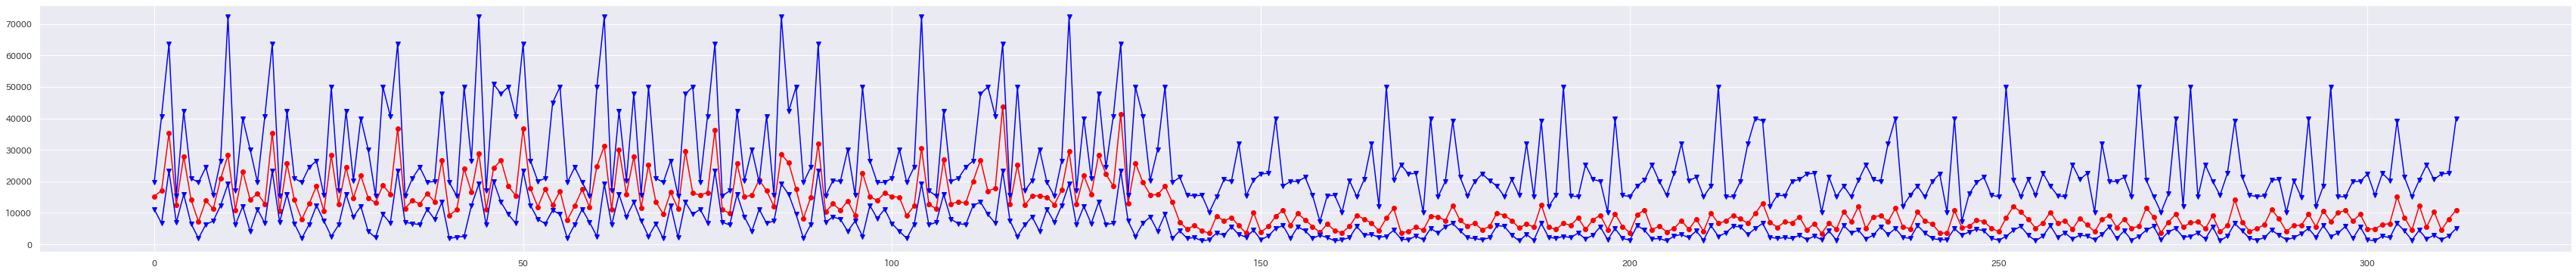

In [585]:
figure(num=None, figsize=(60, 6))
# 予測値
plt.plot(pred_LR1_df.index, sample[1], color = 'red', marker = 'o')

# スタジオのcapaとスタジオの実績最小値
plt.plot(pred_LR1_df.index, pred_LR1_df['capa'], color = 'blue', marker = 'v')
plt.plot(pred_LR1_df.index, pred_LR1_df['stadium_min'], color = 'blue', marker = 'v')

plt.show()

# 残差分析・特徴量選択
- trainデータへの予測値を求め、実績値との残差を比較し、特徴量として不足していそうなものを検討する

In [586]:
train.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'tv_num', 'home_lat',
       'home_long', 'away_lat', 'away_long', 'distance_km', 'mobilization',
       'stage_stadium', 'stadium_mobilization', 'MONTH', 'WEEK', 'timezone',
       'WEEK_timezone_num', 'nhk', 'WEATHER', 'temp_condition', 'hours',
       'over_mobilization', 'holiday', 'referee_point', 'stadium_min',
       'stadium_max', 'train'],
      dtype='object')

In [587]:
train["pred"] = model1.predict(trainX)
train["res"] = train["y"] - train["pred"]
train.sort_values(by="res")[["res","y","capa","pred","temperature","stage","stadium","match","gameday","weather","humidity","time","home","away","tv"]].head(50)

,res,y,capa,pred,temperature,stage,stadium,match,gameday,weather,humidity,time,home,away,tv
812,-11536.335869,23295,63700,34831.335869,15.6,Ｊ１,埼玉スタジアム２００２,第５節第１日,04/06(土),雨,95%,19:04,浦和レッズ,ジュビロ磐田,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
29,-10810.574944,25743,63700,36553.574944,10.0,Ｊ１,埼玉スタジアム２００２,第４節第１日,03/31(土),雨,65%,15:03,浦和レッズ,川崎フロンターレ,スカパー／ｅ２／スカパー光／テレ玉
914,-10788.582413,23725,63700,34513.582413,24.1,Ｊ１,埼玉スタジアム２００２,第１７節第１日,07/17(水),雨,87%,19:05,浦和レッズ,横浜Ｆ・マリノス,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
262,-9543.473434,32090,63700,41633.473434,20.1,Ｊ１,埼玉スタジアム２００２,第３０節第１日,10/27(土),晴,45%,14:03,浦和レッズ,セレッソ大阪,スカパー！／スカパー！プレミアムサービス／ＢＳ－ＴＢＳ／テレ玉
1033,-9092.776459,34814,63700,43906.776459,17.3,Ｊ１,埼玉スタジアム２００２,第３０節第２日,10/27(日),晴,38%,16:05,浦和レッズ,柏レイソル,スカパー！／スカパー！プレミアムサービス／テレ玉／ＮＨＫ総合
40,-9018.574646,15854,42300,24872.574646,3.4,Ｊ１,デンカビッグスワンスタジアム,第５節第１日,04/07(土),曇,63%,15:04,アルビレックス新潟,横浜Ｆ・マリノス,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ新潟
32,-8857.193718,16836,42300,25693.193718,7.1,Ｊ１,デンカビッグスワンスタジアム,第４節第１日,03/31(土),雨,64%,16:03,アルビレックス新潟,ガンバ大阪,スカパー／ｅ２／スカパー光
1588,-8498.242081,26762,63700,35260.242081,7.7,Ｊ１,埼玉スタジアム２００２,第６節第１日,04/06(日),晴,32%,19:04,浦和レッズ,ベガルタ仙台,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
163,-8407.665207,28142,63700,36549.665207,31.3,Ｊ１,埼玉スタジアム２００２,第１９節第１日,07/28(土),晴,62%,18:03,浦和レッズ,ジュビロ磐田,スカパー／ｅ２／スカパー光／テレ玉
819,-8094.783340,13384,47816,21478.783340,13.3,Ｊ１,ヤンマースタジアム長居,第６節第１日,04/13(土),晴,31%,19:04,セレッソ大阪,大宮アルディージャ,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１


In [588]:
train.sort_values(by="res",ascending=False)[["res","y","capa","pred","temperature","stage","stadium","match",'year',"gameday",'referee',"weather","humidity","time","home","away","tv"]].head(50)

,res,y,capa,pred,temperature,stage,stadium,match,year,gameday,referee,weather,humidity,time,home,away,tv
1059,27219.609421,62632,72327,35412.390579,12.7,Ｊ１,日産スタジアム,第３３節第１日,2013,11/30(土),家本 政明,晴,33%,14:04,横浜Ｆ・マリノス,アルビレックス新潟,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合
1591,16114.453339,42723,47816,26608.546661,18.0,Ｊ１,ヤンマースタジアム長居,第７節第２日,2014,04/12(土),西村 雄一,晴,22%,14:04,セレッソ大阪,ガンバ大阪,スカパー！／スカパー！プレミアムサービス／ＮＨＫ大阪
784,15885.786957,52293,63700,36407.213043,21.6,Ｊ１,埼玉スタジアム２００２,第２節第１日,2013,03/09(土),佐藤 隆治,晴,24%,16:05,浦和レッズ,名古屋グランパス,スカパー！／スカパー！プレミアムサービス／テレ玉（録）
1631,14140.402100,38966,40000,24825.597900,17.8,Ｊ１,豊田スタジアム,第１１節第１日,2014,05/03(土・祝),山本 雄大,晴,33%,19:04,名古屋グランパス,セレッソ大阪,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／名古屋テレビ（録）
1566,13475.164001,32099,40728,18623.835999,13.9,Ｊ１,県立カシマサッカースタジアム,第４節第１日,2014,03/23(日),吉田 寿光,晴,38%,15:04,鹿島アントラーズ,セレッソ大阪,スカパー！／スカパー！プレミアムサービス
1066,13320.917557,54905,63700,41584.082443,12.6,Ｊ１,埼玉スタジアム２００２,第３４節第１日,2013,12/07(土),木村 博之,晴,37%,15:34,浦和レッズ,セレッソ大阪,スカパー！／スカパー！プレミアムサービス／テレ玉
1602,12869.309586,40761,49970,27891.690414,13.2,Ｊ１,味の素スタジアム,第８節第１日,2014,04/19(土),家本 政明,曇,46%,16:04,ＦＣ東京,セレッソ大阪,スカパー！／スカパー！プレミアムサービス
4,12818.797340,25353,39232,12534.202660,22.5,Ｊ１,札幌ドーム,第１節第１日,2012,03/10(土),廣瀬 格,屋内,32%,14:04,コンサドーレ札幌,ジュビロ磐田,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌
947,12532.983841,23814,40000,11281.016159,31.3,Ｊ１,大分銀行ドーム,第２０節第１日,2013,08/10(土),松尾 一,晴,62%,19:05,大分トリニータ,柏レイソル,スカパー！／スカパー！プレミアムサービス
298,12302.796600,51879,63700,39576.203400,5.6,Ｊ１,埼玉スタジアム２００２,第３４節第１日,2012,12/01(土),村上 伸次,晴,71%,15:34,浦和レッズ,名古屋グランパス,スカパー！／スカパー！プレミアムサービス／ＢＳ－ＴＢＳ／テレ玉
